## Setup

In [1]:
!pip install -U tensorflow-addons

     -------------------------------------- 746.7/746.7 kB 2.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import os
import pandas as pd
import json
import cv2
import tensorflow_hub as hub

from keras import layers, models, optimizers, regularizers
from keras.applications import EfficientNetB0
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

c:\Users\Geran\anaconda3\envs\tfgpu_landclass\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
path = 'dataset'
# loads directory of 3 datasets
dir_train = pd.read_csv(path + '/EuroSAT/train.csv')
dir_valid = pd.read_csv(path + '/EuroSAT/validation.csv')
dir_test = pd.read_csv(path + '/EuroSAT/test.csv')

In [16]:
img_dir = pd.concat([dir_train, dir_valid], ignore_index=False)
img_dir = img_dir.iloc[:,1:-1].reset_index().drop(['index'], axis=1) # why was it :,1:-1? that removes classname
img_dir

,Filename,Label,ClassName
0,AnnualCrop/AnnualCrop_142.jpg,0,AnnualCrop
1,HerbaceousVegetation/HerbaceousVegetation_2835...,2,HerbaceousVegetation
2,PermanentCrop/PermanentCrop_1073.jpg,6,PermanentCrop
3,Industrial/Industrial_453.jpg,4,Industrial
4,HerbaceousVegetation/HerbaceousVegetation_1810...,2,HerbaceousVegetation
...,...,...,...
24295,SeaLake/SeaLake_1943.jpg,9,SeaLake
24296,AnnualCrop/AnnualCrop_211.jpg,0,AnnualCrop
24297,Industrial/Industrial_1428.jpg,4,Industrial
24298,AnnualCrop/AnnualCrop_2571.jpg,0,AnnualCrop


In [18]:
# Load images and labels/classes
images = []
classes = []

base_path = path + '/EuroSAT/'
for index, row in img_dir.iterrows():
    img_path = base_path + row['Filename']
    img = cv2.imread(img_path)
    try:
        print('Original size',img.shape)
        img = cv2.resize(img, (64, 64))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        classes.append(row['ClassName'])
    except AttributeError:
        print("shape not found")
        


# Normalize images
images = np.array(images) / 255.0
labels = pd.get_dummies(classes).values

Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original size (64, 64, 3)
Original siz

## Prepare the data

In [17]:
num_classes = 10
input_shape = (64, 64, 3)

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Set up the data augmentation
train_data_generator = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)
valid_data_generator = ImageDataGenerator()

NameError: name 'images' is not defined

## Configure the hyperparameters

In [8]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


## Use data augmentation

In [9]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


2023-04-20 20:58:41.856783: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Implement multilayer perceptron (MLP)

In [10]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement patch creation as a layer

In [11]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Let's display patches for a sample image

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


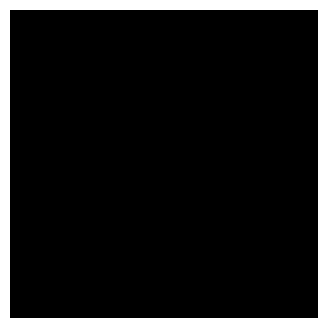

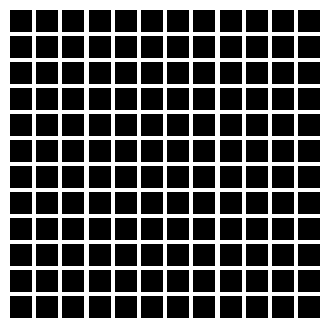

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

In [13]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


## Build the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via an
classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.
Note that the `layers.GlobalAveragePooling1D` layer
could also be used instead to aggregate the outputs of the Transformer block,
especially when the number of patches and the projection dimensions are large.

In [14]:

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Compile, train, and evaluate the mode

In [15]:

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

     
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


Epoch 1/10
69/69 [==============================] - 721s 10s/step - loss: 2.2543 - accuracy: 0.4140 - top-5-accuracy: 0.8657 - val_loss: 1.0914 - val_accuracy: 0.6142 - val_top-5-accuracy: 0.9676
Epoch 2/10
69/69 [==============================] - 663s 10s/step - loss: 1.0891 - accuracy: 0.6147 - top-5-accuracy: 0.9693 - val_loss: 0.8356 - val_accuracy: 0.7227 - val_top-5-accuracy: 0.9877
Epoch 3/10
69/69 [==============================] - 617s 9s/step - loss: 0.8732 - accuracy: 0.7005 - top-5-accuracy: 0.9837 - val_loss: 0.6919 - val_accuracy: 0.7562 - val_top-5-accuracy: 0.9918
Epoch 4/10
69/69 [==============================] - 537s 8s/step - loss: 0.7399 - accuracy: 0.7499 - top-5-accuracy: 0.9886 - val_loss: 0.7086 - val_accuracy: 0.7757 - val_top-5-accuracy: 0.9918
Epoch 5/10
69/69 [==============================] - 538s 8s/step - loss: 0.6025 - accuracy: 0.7982 - top-5-accuracy: 0.9917 - val_loss: 0.5356 - val_accuracy: 0.8174 - val_top-5-accuracy: 0.9964
Epoch 6/10
69/69 [=====

69/69 [==============================] - 539s 8s/step - loss: 0.4255 - accuracy: 0.8594 - top-5-accuracy: 0.9973 - val_loss: 0.3790 - val_accuracy: 0.8771 - val_top-5-accuracy: 0.9974
Epoch 9/10
69/69 [==============================] - 538s 8s/step - loss: 0.4021 - accuracy: 0.8682 - top-5-accuracy: 0.9978 - val_loss: 0.4454 - val_accuracy: 0.8508 - val_top-5-accuracy: 0.9974
Epoch 10/10
152/152 [==============================] - 52s 342ms/step - loss: 0.3732 - accuracy: 0.8809 - top-5-accuracy: 0.9984
Test accuracy: 88.09%
Test top 5 accuracy: 99.84%


In [16]:
vit_classifier.save("vit_classifier")

INFO:tensorflow:Assets written to: vit_classifier/assets


INFO:tensorflow:Assets written to: vit_classifier/assets
